라이브러리 버전 확인

In [1]:
import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


### Step 1. 스티커와 이미지 불러오기

이미지 불러오기

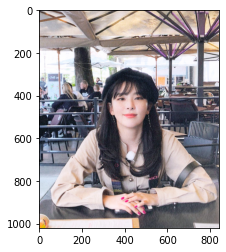

In [2]:
import matplotlib.pyplot as plt

img_bgr = cv2.imread("/aiffel/aiffel/camera_sticker/images/image_face.jpg")
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### Step 2. 얼굴 검출 & 랜드마크 검출 하기

detector 선언

In [3]:
detector_hog = dlib.get_frontal_face_detector()

detector를 이용하여 bounding box 추출하기

In [4]:
dlib_rects = detector_hog(img_rgb, 1)
dlib_rects

rectangles[[(324, 366) (510, 552)]]

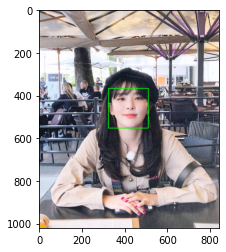

In [5]:
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

랜드마크 검출하기

In [6]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [7]:
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


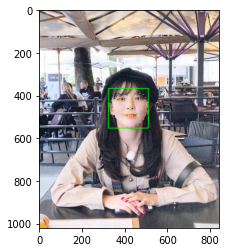

In [9]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Step 3. 스티커 적용 위치 확인하기

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(426, 469)
(x,y) : (426,469)
(w,h) : (187,187)


- 코 끝인 33번에 스티커가 위치하도록함.

### Step 4. 스티커 적용하기

고양이 수염 이미지 불러오기

원래 사이즈:  (512, 512, 3)
변환한 사이즈:  (187, 187, 3)


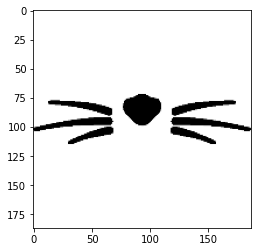

In [11]:
img_sticker = cv2.imread('/aiffel/aiffel/camera_sticker/images/cat_whiskers.png')
print('원래 사이즈: ', img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print ('변환한 사이즈: ', img_sticker.shape)
sticker_show = img_sticker #.copy()
plt.imshow(sticker_show)

In [12]:
refined_x = x - w // 2
refined_y = y  - dlib_rect.width()//2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (333,376)


- 스티커의 중간에 코 끝이 위치하도록 만든다.
- refined_x는 (코 끝의 x좌표) - (스티커 사이즈/2) // refinded_y는 (코 끝의 y좌표) - (스티커 사이즈/2)

In [13]:
import numpy as np

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

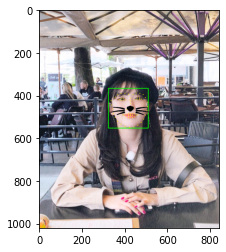

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

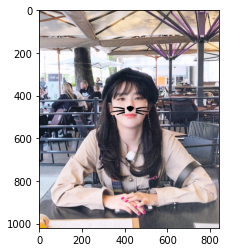

In [15]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### Step 5. 문제점 찾아보기

#### 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보기

#### 이미지2: 고개를 기울인 사진
고개를 기울인 사진에 스티커를 어떻게 붙일까?

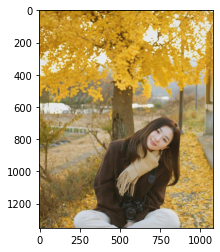

In [16]:
img2 = cv2.imread("/aiffel/aiffel/camera_sticker/images/image_leaves.png")
img_show2 = img2.copy()
img_rgb2 = cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb2)
plt.show()

In [17]:
dlib_rects = detector_hog(img_rgb2, 3)
dlib_rects

rectangles[[(673, 735) (811, 874)]]

- detector_hog의 두번째 파라미터인 이미지 피라미드의 수는 upsampling을 몇 번 하는지를 의미한다. 피라미드를 1개 쌓으니 사진에서 얼굴의 크기가 너무 작아서 그런지 rectangles 값이 빈 리스트로 나와 피라미드 수를 2로 바꾸었다.

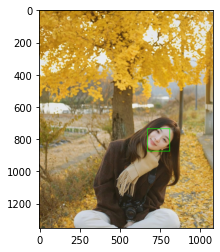

In [18]:
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
cv2.rectangle(img_show2, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [19]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


In [20]:
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

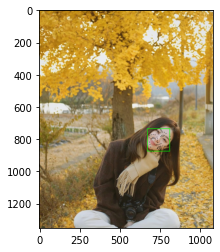

In [21]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show2, point, 2, (0, 0, 0), -1)
            
img_show_rgb2 = cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

- 얼굴을 기울인 사진에서는 landmark 모델이 얼굴 형태 및 이목구비의 위치를 제대로 인식하지 못했다.
- 위 사진에서는 얼굴이 차지하는 공간의 크기가 너무 작아 landmark가 나타나지 않는 것 같다.

#### 이미지3: 얼굴을 기울인 사진2

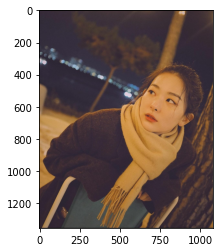

In [22]:
img_bgr3 = cv2.imread("/aiffel/aiffel/camera_sticker/images/image_night.png")
img_show3 = img_bgr3.copy()
img_rgb3 = cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb3)
plt.show()

In [23]:
dlib_rects = detector_hog(img_rgb3, 1)
dlib_rects

rectangles[[(587, 468) (854, 736)]]

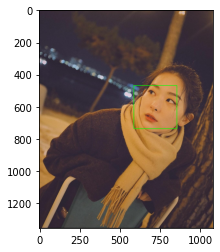

In [24]:
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
cv2.rectangle(img_show3, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [25]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb3, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


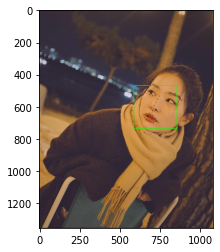

In [26]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show3, point, 2, (0, 0, 0), -1)
            
img_show_rgb = cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- hog는 색상의 변화량을 계산하는데 주변 배경과 얼굴의 색상 차이가 많이 나지 않아서 얼굴 윤곽선을 인식하지 못한 것 같다.

In [27]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(703, 622)
(x,y) : (703,488)
(w,h) : (268,268)


In [28]:
img_sticker = cv2.imread('/aiffel/aiffel/camera_sticker/images/cat_whiskers.png')
print('원래 사이즈: ', img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print ('변환한 사이즈: ', img_sticker.shape)
sticker_show = img_sticker

원래 사이즈:  (512, 512, 3)
변환한 사이즈:  (268, 268, 3)


In [29]:
refined_x = x - w // 2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (569,488)


In [30]:
sticker_area = img_show3[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show3[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

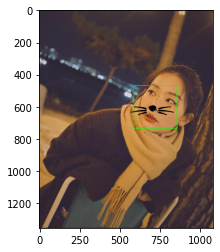

In [31]:
plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

- 얼굴의 각도와 고양이 수염 스티커의 각도가 조금 달라 부자연스럽다.
- 고양이 수염 스티커의 각도를 조금 회전시키면 문제가 해결될 것 같다.

In [32]:
import math

height, width, channel = img_sticker.shape
ang = math.atan(h/w)/math.pi*180
matrix = cv2.getRotationMatrix2D((width/2, height/2), -ang, 1)
dst = cv2.warpAffine(img_sticker, matrix, (width, height))

In [33]:
sticker_area = img_show3[refined_y:refined_y+dst.shape[0], refined_x:refined_x+dst.shape[1]]
img_show3[refined_y:refined_y+dst.shape[0], refined_x:refined_x+dst.shape[1]] = \
np.where(dst==255,sticker_area,dst).astype(np.uint8)

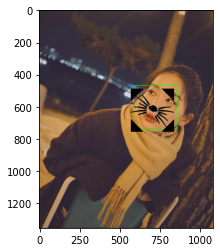

In [34]:
plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

수염 스티커를 회전하면서 빈 공간이 검은색으로 채워졌다.
- 1 회전을 시킨 상태로 스티커를 불러오거나
- 2 빈 공간을 검은색이 아니라 원본 이미지로 채우거나
- 3 빈 공간을 검은색이 아니라 흰색으로 바꾸면 자연스럽게 만들 수 있을 것 같다.

빈 공간을 흰색으로 채우기

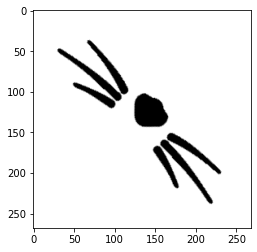

In [35]:
height, width, channel = img_sticker.shape
ang = math.atan(h/w)/math.pi*180
matrix = cv2.getRotationMatrix2D((width/2, height/2), -ang, 1)
img_sticker = cv2.warpAffine(img_sticker, matrix, (width, height), flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
sticker_show = img_sticker
plt.imshow(sticker_show)
plt.show()

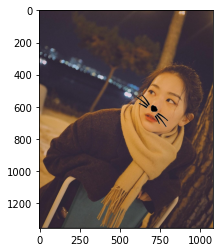

In [36]:
sticker_area = img_bgr3[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] 
img_bgr3[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr3, cv2.COLOR_BGR2RGB))
plt.show()

#### 이미지4: 안경 낀 얼굴 사진
안경 낀 얼굴 사진은 인식할까?

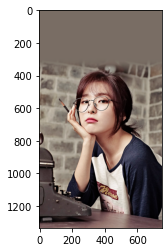

In [37]:
img_bgr4 = cv2.imread("/aiffel/aiffel/camera_sticker/images/image_glasses.png")
img_show4 = img_bgr4.copy()
img_rgb4 = cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb4)
plt.show()

In [38]:
dlib_rects = detector_hog(img_rgb4, 1)
dlib_rects

rectangles[[(200, 468) (468, 736)]]

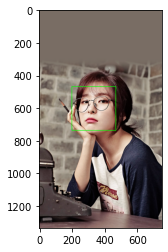

In [39]:
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
cv2.rectangle(img_show4, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [40]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb4, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


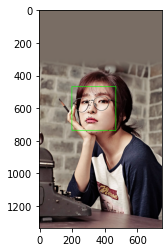

In [41]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show4, point, 2, (0, 0, 0), -1)
            
img_show_rgb = cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [42]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(314, 632)
(x,y) : (314,498)
(w,h) : (269,269)


In [43]:
img_sticker = cv2.imread('/aiffel/aiffel/camera_sticker/images/cat_whiskers.png')
print('원래 사이즈: ', img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print ('변환한 사이즈: ', img_sticker.shape)
sticker_show = img_sticker #.copy()

원래 사이즈:  (512, 512, 3)
변환한 사이즈:  (269, 269, 3)


In [44]:
refined_x = x - w // 2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (180,498)


In [45]:
sticker_area = img_show4[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show4[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

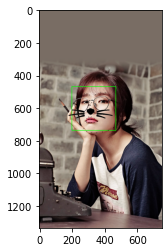

In [46]:
plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

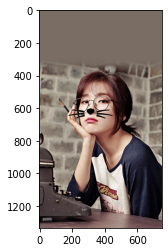

In [47]:
sticker_area = img_bgr4[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] 
img_bgr4[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr4, cv2.COLOR_BGR2RGB))
plt.show()

#### 이미지4: 선글라스 낀 얼굴 사진
그렇다면 선글라스를 낀 사진은 얼굴을 인식할까?

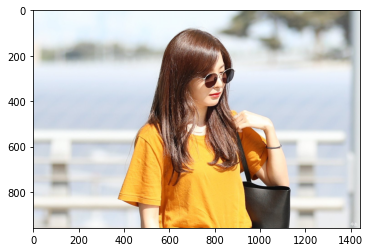

In [48]:
img_bgr5 = cv2.imread("/aiffel/aiffel/camera_sticker/images/image_sunglasses.jpeg")
img_show5 = img_bgr5.copy()
img_rgb5 = cv2.cvtColor(img_show5, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb5)
plt.show()

In [49]:
dlib_rects = detector_hog(img_rgb5, 1)
dlib_rects

rectangles[[(696, 222) (882, 407)]]

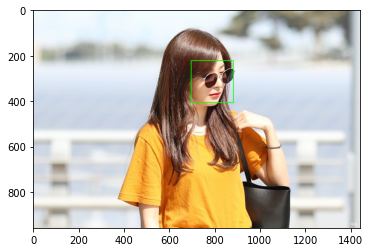

In [50]:
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
cv2.rectangle(img_show5, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show5, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [51]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb5, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


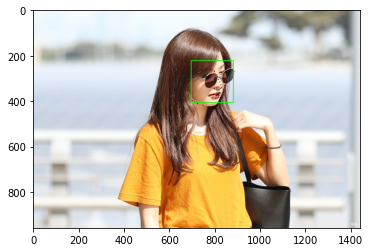

In [52]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show5, point, 2, (0, 0, 0), -1)
            
img_show_rgb = cv2.cvtColor(img_show5, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [53]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(818, 348)
(x,y) : (818,255)
(w,h) : (187,187)


In [54]:
img_sticker = cv2.imread('/aiffel/aiffel/camera_sticker/images/cat_whiskers.png')
print('원래 사이즈: ', img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print ('변환한 사이즈: ', img_sticker.shape)
sticker_show = img_sticker #.copy()

원래 사이즈:  (512, 512, 3)
변환한 사이즈:  (187, 187, 3)


In [55]:
refined_x = x - w // 2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (725,255)


In [56]:
sticker_area = img_show5[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show5[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

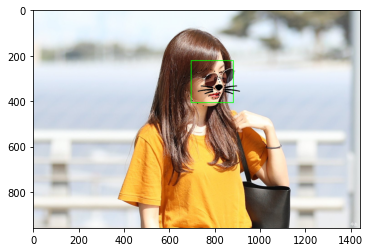

In [57]:
plt.imshow(cv2.cvtColor(img_show5, cv2.COLOR_BGR2RGB))
plt.show()

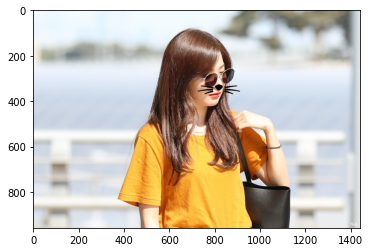

In [58]:
sticker_area = img_bgr5[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] 
img_bgr5[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr5, cv2.COLOR_BGR2RGB))
plt.show()

### 회고

<ol>
<ul> 1. <strong>프로젝트 설명</strong>
    <p> 인물 사진에 고양이 수염 스티커를 합성하는 모델을 만드는 프로젝트를 진행하였다. 다양한 사진에 고양이 수염 스티커를 잘 어울리게 만드는 것이 목적이다.</p>
</ul>
<ul> 2. <strong>시도한 것들</strong>
    <li> 정면사진, 고개를 기울인 사진, 안경 낀 사진, 선글라스 낀 사진 등 다양한 사진을 사용하여 얼굴 위치를 인식하는지(dectector)-이목구비를 인식하는지(landmark) 확인하고 스티커를 붙이는 작업을 하였다.</li>
    <li> 이미지2의 경우 사진에서 얼굴이 차지하는 공간이 너무 작아 hog_detector가 얼굴을 인식하지 못하는 문제가 있었다. 피라미드 파라미터의 수를 늘려 upsampling을 진행하며 문제를 해결했다. 그러나 landmark 도출 또한 안 되어서 파라미터를 바꾸어가며 시도해보았으나 실패했다.</li>
    <li> 얼굴을 기울인 사진(회전한 사진)은 스티커를 회전했을 때 빈 공간이 검은색 공간으로 나왔다. 빈 공간의 색을 검은색에서 흰색으로 바꾸어 문제를 해결했다.</li>
</ul>
<ul> 3. <strong>알게된 점</strong>
    <li> png 파일의 배경은 투명인데, 사진을 불러올 때 흰색 배경이 나오는 경우가 있어 배경을 제거할 필요가 있었다. 이때 np.where의 파라미터로 들어간 img_sticker의 값을 255로 바꾸니 배경이 제거된 상태로 불러올 수 있었다. np.where는 np.where(조건, True, False)로 조건이 img_sticker=255일 때, 하얀색인 부분은 두번째 자리의 파라미터, 하얀색이 아니라면 세번째 자리의 파라미터를 출력하게 된다.</li>
</ul>
<ul> 4. <strong>어려웠던 점</strong>
    <li> 라이브러리의 문제로 얼굴의 landmark가 나오지 않아서 사진에 스티커를 붙이기 어려운 상황이 있었다. 사람 얼굴이 존재하지 않는 배경에서 얼굴을 인식하고 landmark가 나타나기도 했다. </li>
    <li> 얼굴을 기울인 사진에서는 고양이 수염 스티커를 회전시킬 필요가 있었는데, 이미지 회전을 위해 각도를 파악하는 것이 어려웠다. 더불어 회전시킨 스티커의 주변부에 검은색 공간을 제거하는 것도 조금 어려웠다.</li>
</ul>
<ul> 5. <strong>아쉬운 점</strong>
    <li> dlib가 어떻게 이목구비 위치를 파악하여 landmark를 보여주는지 알고 싶다. 이미지2와 같이 landmark 도출이 잘 안 되는 경우 왜 잘 안되는지 문제를 파악하면 문제 해결이 가능할 것 같다. </li>
    <li> 고양이 수염 스티커의 크기를 앞쪽은 크게, 뒤쪽은 작게 조절하여 원근감을 표현였다면 사진이 더 자연스럽게 보일 것 같다.</li>
</ul>
</ol>